Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
## If you are using the data by mounting the google drive, use the following :
import zipfile
from google.colab import drive


drive.mount('/content/drive', force_remount=True)

## commeted out code to unzip the CNN_assignment.zip
## zip_ref = zipfile.ZipFile("/content/drive/My Drive/ML/CNN_assignment.zip", 'r')
## zip_ref.extractall("/content/drive/My Drive/ML/CNN_assignment")
## zip_ref.close()

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/My Drive/ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
               directory=data_dir_train, labels='inferred', label_mode='categorical', class_names=None,
               color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),
               shuffle=True, seed=123, validation_split=.20, subset="training",
              interpolation='nearest', follow_links=False)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
              directory=data_dir_train, labels='inferred', label_mode='categorical', class_names=None,
              color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),
              shuffle=False, seed=123, validation_split=.20, subset="validation",
              interpolation='nearest', follow_links=False)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [32]:
## Loading the test dataset

test_ds=tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_test,
        labels='inferred', label_mode='categorical', class_names=None,
        color_mode='rgb',
        image_size=(img_height,img_width),
        seed=123
       
    )

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

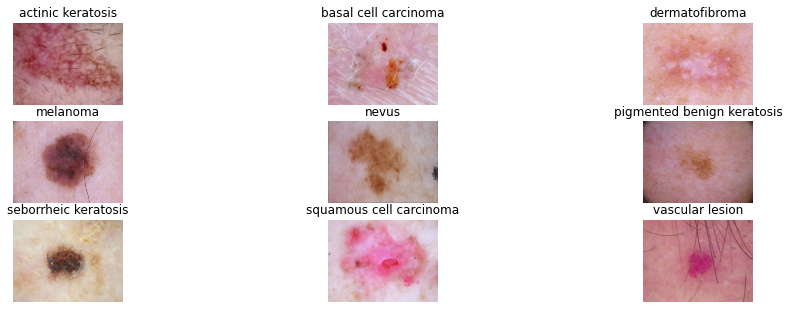

In [15]:
from os import listdir
from os.path import join
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
%matplotlib inline
image_indexes = [0]
selected_image_file_paths = dict()
for classification in class_names:
    image_directory = join(data_dir_train, classification)
    image_file_names = listdir(image_directory)
    selected_image_file_paths[classification] = [join(image_directory, image_file_names[i]) for i in image_indexes]

number_classes = len(class_names)
plt.figure(figsize=(16,16))    
for i,classification in enumerate(class_names):
    for j,image in enumerate(selected_image_file_paths[classification]):
        image_number = (i * len(image_indexes)) + j + 1
        ax = plt.subplot(number_classes,3,image_number)
        plt.title(classification)
        plt.axis("off")
        plt.imshow(mpimg.imread(image))



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
### Your code goes here

color_mode = "rgb"
number_colour_layers = 3
image_size = (img_height, img_width)
image_shape = image_size + (number_colour_layers,)

preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape)
]

In [19]:
def conv_2d_pooling_layers(filters, number_colour_layers):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D()
    ]
core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    conv_2d_pooling_layers(64, number_colour_layers)

In [20]:
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_classes)
]

In [21]:
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [22]:
### Todo, choose an appropirate optimiser and loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 25s 74ms/step - loss: 2.0929 - accuracy: 0.2404 - val_loss: 2.6749 - val_accuracy: 0.0000e+00
Epoch 2/20
56/56 [==============================] - 1s 18ms/step - loss: 1.7430 - accuracy: 0.3603 - val_loss: 1.9351 - val_accuracy: 0.2796
Epoch 3/20
56/56 [==============================] - 1s 17ms/step - loss: 1.5928 - accuracy: 0.4454 - val_loss: 1.4907 - val_accuracy: 0.4139
Epoch 4/20
56/56 [==============================] - 1s 17ms/step - loss: 1.3527 - accuracy: 0.5140 - val_loss: 1.5854 - val_accuracy: 0.3043
Epoch 5/20
56/56 [==============================] - 1s 17ms/step - loss: 1.2705 - accuracy: 0.5678 - val_loss: 1.5687 - val_accuracy: 0.4004
Epoch 6/20
56/56 [==============================] - 1s 17ms/step - loss: 1.2147 - accuracy: 0.5775 - val_loss: 1.4259 - val_accuracy: 0.4049
Epoch 7/20
56/56 [==============================] - 1s 17ms/step - loss: 1.0852 - accuracy: 0.6207 - val_loss: 1.3274 - val_accuracy: 0.4832
Epoch 8/

### Visualizing training results

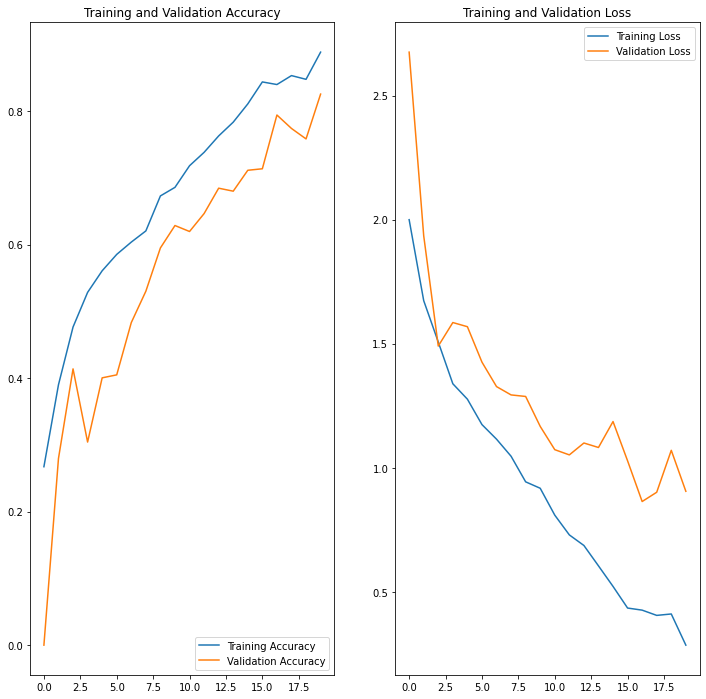

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

###Observation

At the end of 20 epochs , the model training has been completed and the training accuracy is between **95% to 98%**.In general ,This is more likely due to careful control of the conditions in which the data was captured or some augmentation of the images rather than the model itself being particularly good, as it has not been **optimised**.


In [34]:
## Let's evaluate the model on the test data
model.evaluate(test_ds)

4/4 [==============================] - 4s 13ms/step - loss: 5.9390 - accuracy: 0.3475


[5.939036846160889, 0.347457617521286]

### Observation

For our initial model,

Training Accuracy : 95%

Test Accuracy     : 34.75%

**This is a clear case of model overfitting**


### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here



### Compiling the model

In [ ]:
## Your code goes here

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = ## your training code

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

